In [77]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")

LReg (generic function with 1 method)

# Implicit Three Level Deferred Correction (Reference Solution)

In [3]:
function R3imp(f, a, b, u0, lambda, N)
    dt=(b-a)/N
    t=(0:N)*dt
    m=2
    DT1=m*dt
    DT2=m*DT1
    U=zeros(1, N+1, 3)
    
    U[1, 1, 1]=u0
    U[1, 1, 2]=u0
    U[1, 1, 3]=u0

    for i=1:m^2:N
        U[1, i, 2]=U[1, i, 3] # Injection from the third level
        for j=i:m:i+2
            U[1, j, 1]=U[1, j, 2] # Injection from the second level
            for k=j:j+1
                U[1, k+1, 1] = U[1, k, 1] / (1 .- lambda*dt)
            end
            U[1, j+2, 2]= (U[1, j, 2] .- lambda*DT1 * U[1, j+2, 1] + Lagrange(t[j:j+2], f(t[j:j+2], U[1, j:j+2, 1]), t[j], t[j+2])) / (1 .- lambda*DT1)
        end
        U[1, i+4, 3]= (U[1, i, 3] .- lambda*DT2 * U[1, i+4, 2] + Lagrange(t[i:m:i+4], f(t[i:m:i+4], U[1, i:m:i+4, 2]), t[i], t[i+4])) / (1 .- lambda*DT2)
    end
        
    return  U, t
end

R3imp (generic function with 1 method)

convergence order = 2.8467057093521255


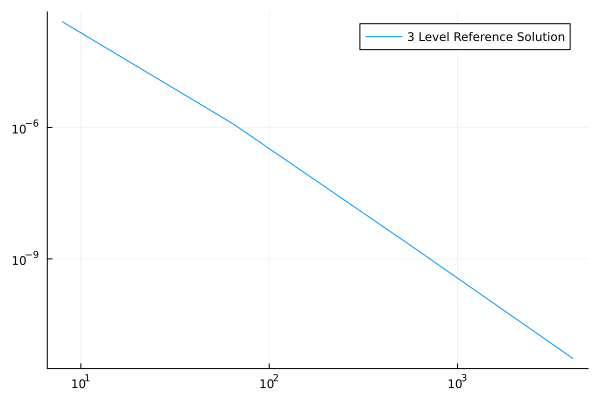

In [5]:
# Convergence rate test of reference solution
using LinearAlgebra

u0 = 1.0
a=0
b=1.0
K = 4
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
lambda= -1.0
f(t, u) = lambda*u

for k in 1:K
    
    N = 8^k
    
    ns[k]=N
    Uim, t= R3imp(f, a, b, u0, lambda, N)
    exact= u0*exp.(lambda*t)
    err[k] = norm(exact[1:m^2:end] .- Uim[1, 1:m^2:end, 3], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="3 Level Reference Solution")
display(plot!(legend=:topright))

In [7]:
function Imp_num3(f, a, b, N, u0, lambda, K)
    
    dt = (b - a)/ N
    m = 2 
    DT1 = m*dt
    DT2 = m*DT1
    u = zeros(1, N + 1, K + 1)
    u[1, 1, 1] = u0
    ps = 3:m:N
    ps2=5:m^2:N
    u[1, ps2, 1] = ones(length(ps2)) # initializing random values
    t = (0:N)*dt
    up = zeros(N + 1)
    up[1] = u0
    uc = zeros(1, N + 1, K+1)
    uc[1, 1, 1] = u0
    uc[1, ps, 1] = ones(length(ps)) # initializing random values

    for k in 1:K
        
        u[1, 1, k+1] = u0
        uc[1, 1, k+1]= u0
        
        # F-relaxation on level 1
        for i=1:m:N
            up[i]=uc[1, i, k] # Injection from Level 2
            up[i+1]=up[i]/(1 .- lambda*dt)
        end
        # C-relaxation on level 1
        for j=2:m:N
            up[j+1]= up[j]/(1 .- lambda*dt)
        end

        
        
        # F-relaxation on level 2
        for n =1:m^2:N
            uc[1, n, k+1]=u[1, n, k] # Injection from the third level
             uc[1, n+2, k+1] = (uc[1, n, k+1] - lambda*DT1* up[n+2] + Lagrange(t[n:n+2], f(t[n:n+2], [u[1, n, k]; up[n+1:n+2]]), t[n], t[n+2]))/(1 .- lambda*DT1)
            #uc[1, n+2, k+1] = (uc[1, n, k+1] - lambda*DT1*f(t[n], up[n+2]) + lambda*DT1*((1/6)*u[1, n, k]+(2/3)*up[n+1]+(1/6)*up[n+2]))/(1 .- lambda*DT1)
        end
        # C-relaxation on level 2
        for l=3:m^2:N
            uc[1, l+2, k+1] = (uc[1, l, k+1] - lambda*DT1* up[l+2] + Lagrange(t[l:l+2], f(t[l:l+2], [uc[1, l, k]; up[l+1:l+2]]), t[l], t[l+2]))/(1 .- lambda*DT1)
            #uc[1, l+2, k+1] = (uc[1, l, k+1] - lambda*DT1*f(t[l], up[l+2]) + lambda*DT1*((1/6)*uc[1, l, k]+(2/3)*up[l+1]+(1/6)*up[l+2]))/(1 .- lambda*DT1)
        end

        # Coarse-grid correction on level 3
        for z=1:m^2:N
            uc[1, z, k+1]=u[1, z, k]
            u[1, z+4, k+1]=(u[1, z, k+1] - lambda*DT2*uc[1, z+4, k+1] +Lagrange(t[z:m:z+4], f(t[z:m:z+4], uc[1, z:m:z+4, k+1]), t[z], t[z+4]))/(1 .- lambda*DT2)
            #u[1, z+4, k+1]=(u[1, z, k+1] - lambda*DT2*f(t[z], uc[1, z+4, k+1]) +lambda*DT2*((1/6)*uc[1, z, k+1]+(2/3)*uc[1, z+m, k+1]+(1/6)*uc[1, z+4, k+1]))/(1 .- lambda*DT2)
        end
        
    end

    return  u, t
end

Imp_num3 (generic function with 1 method)

convergence order = 2.8467057083570477


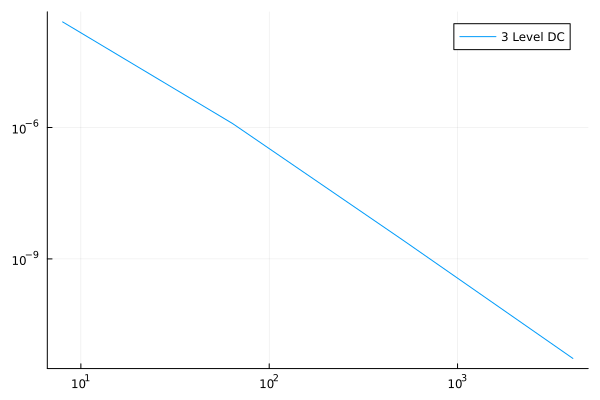

In [9]:
using LinearAlgebra

u0 = 1.0
lambda= -1.0
a=0
b=1.0
K = 4
itr=10
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
f(t, u) = lambda * u

for k in 1:K
    
    N = 8^k
    
    ns[k]=N
    u, t= Imp_num3(f, a, b, N, u0, lambda, itr)
    exact= u0*exp.(lambda*t)
    err[k] = norm(exact[1:m^2:end] .- u[1, 1:m^2:end, itr], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="3 Level DC")
display(plot!(legend=:topright))

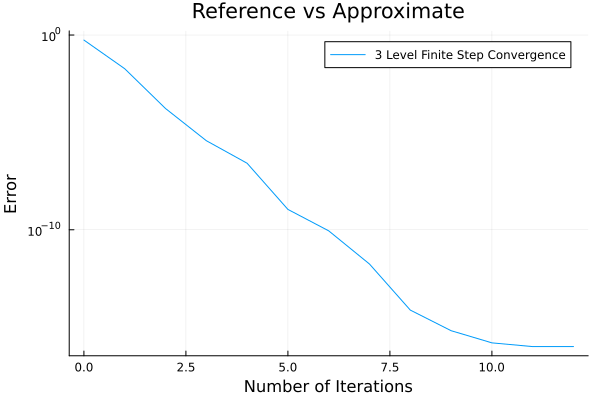

In [11]:
using LinearAlgebra, Plots
lambda= -1.0
u0 = 1.0
a = 0
b = 1.0
f(t, u)= lambda*u
N = 20
K = 12 # Number of Iterations
m = 2
err=zeros(K+1)
u, t= Imp_num3(f, a, b, N, u0, lambda, K) # Approximate Solution
U, t = R3imp(f, a, b, u0, lambda, N) # Reference Solution
for k=1:K+1
    err[k]= norm( U[1, 1:m^2:end, 3] .- u[1, 1:m^2:end, k], Inf ) .+10^(-16)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error", label=" 3 Level Finite Step Convergence", title="Reference vs Approximate")

# The three Level DC in all-at-once system

\begin{align}
A = \begin{bmatrix}
1 &  &  &  &  &  \\
\beta & \alpha_1 &  &  &  &  \\
 & \beta & \alpha_1 &  &  &  \\
c_1 & c_2 & c_3 & \alpha_2 & & \\
 &  &  & \beta & \alpha_1 &  \\
 &  &  & & \beta & \alpha_1 &  &  \\
& & & c_1 & c_2 & c_3 & \alpha_2 & & \\
 &  &  &  &  &  & & \ddots &  \\
 &  &  &  &  & & &\beta & \alpha_1 &  \\
&  &  &  &  & &  & & \beta & \alpha_1  \\
& & & & & & &c_1 & c_2 & c_3 & \alpha_2  \\  
\end{bmatrix} \quad
U=\begin{bmatrix}
u_0^3 \\
u_2^2 \\
u_4^2 \\
u_4^3 \\
u_6^2 \\
u_8^2 \\
u_8^3 \\
\vdots \\
u_{N-2}^2 \\
u_{N}^2 \\
u_{N}^3 \\
\end{bmatrix}\quad
b=\begin{bmatrix}
a \\
0 \\
0 \\
\vdots \\
 \\
 \\
 \\
 \\
\vdots \\
 \\
 \\
0 \\
\end{bmatrix}
\end{align}
where:
\begin{align}
c_1 =-1 - \frac{\Delta T_2}{6} \quad
c_2 = -\frac{2}{3} \Delta T_2,\quad
c_3 = \frac{5}{6} \Delta T_2,
\end{align}
\begin{align}
\alpha_1 &= 1 - \Delta T_1, \\
\alpha_2 &= 1 - \Delta T_2, \\
\beta &= -1 + \Delta T_1 \left( \frac{5}{6} \frac{1}{(1 - \Delta t)^2} - \frac{2}{3} \frac{1}{1 - \Delta t} - \frac{1}{6} \right).
\end{align}

In [ ]:
using SparseArrays
function ML3_ref(N, m, u0, lambda)
dt=1/N
DT1=m*dt
DT2=m*DT1
alpha1=(1-lambda*DT1)
alpha2=(1-lambda*DT2)
beta = lambda*DT1*(-(5/6) * 1/(1-lambda*dt).^2 + (2/3)* 1/(1-lambda*dt) +1/6)

c1=-(2.0/3)*DT2
c2=(5/6)*DT2
d1=(1/6)*DT2 
    
n=16
A = spzeros(n, n)
# Assign values to matrix A using a loop based on the shifting pattern in the image
for i in 1:n
    if i == 1
        A[i, i] = 1.0
    elseif i % 3 == 2
        A[i, i] = alpha1
    elseif i % 3 == 0
        A[i, i - 1] = -1.0
        A[i, i] = alpha1
    elseif i % 3 == 1 && i > 1
        A[i, i - 3] = -1.0
        A[i, i - 2] = c1
        A[i, i - 1] = c2
        A[i, i] = alpha2
    end
end
#Construct Matrix B
B = spzeros(n, n)

# Assign values to matrix B using a loop based on the shifting pattern in the image
for i in 1:n
    if i == 1
        B[i, i] = 0.0
    elseif i % 3 == 2
        B[i, i - 1] = 1.0 + beta
    elseif i % 3 == 0
        B[i, i - 1] = beta
    elseif i % 3 == 1 && i > 1
        B[i, i - 3] = d1
    end
end
    
b=zeros(n)
b[1]=u0
v=zeros(n)
vk=ones(n)

# Solve the system using the decomposed matrices
for i=1:n
    v = A \ b + (A \ B) * vk
    vk= v
end
return v
end

In [ ]:
using SparseArrays
function ML3_apprx(N, m, u0, lambda, K)

dt=1/N
DT1=m*dt
DT2=m*DT1
alpha1=(1-lambda*DT1)
alpha2=(1-lambda*DT2)
beta = lambda*DT1*(-(5/6) * 1/(1-lambda*dt).^2 + (2/3)* 1/(1-lambda*dt) + 1/6)

c1=-(2.0/3)*DT2
c2=(5/6)*DT2
d1=(1/6)*DT2  
    
n=16 # Matrix dimension
    
A = spzeros(n, n)
# Assign values to matrix A using a loop based on the shifting pattern in the image
for i in 1:n
    if i == 1
        A[i, i] = 1.0
    elseif i % 3 == 2
        A[i, i] = alpha1
    elseif i % 3 == 0
        A[i, i - 1] = -1.0
        A[i, i] = alpha1
    elseif i % 3 == 1 && i > 1
        A[i, i - 3] = -1.0
        A[i, i - 2] = c1
        A[i, i - 1] = c2
        A[i, i] = alpha2
    end
end
#Construct Maatrix B
B = spzeros(n, n)

# Assign values to matrix B using a loop based on the shifting pattern in the image
for i in 1:n
    if i == 1
        B[i, i] = 0.0
    elseif i % 3 == 2
        B[i, i - 1] = 1.0 + beta
    elseif i % 3 == 0
        B[i, i - 1] = beta
    elseif i % 3 == 1 && i > 1
        B[i, i - 3] = d1
    end
end
    
b=zeros(n)
b[1]=u0
v=zeros(n)
vk=ones(n)

for i in 1:K
    v = A \ b + (A \ B) * vk
    vk = v  # Update vk for the next iteration
end
return v
end

In [ ]:
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda= 1.0
f(t, u) = lambda*u
N = 20
n=16
K = 12 # Number of Iterations
m = 2
err1=zeros(K+1)
err2=zeros(K+1)
Uref=ML3_ref(N, m, u0, lambda)
u_store=zeros(n, K+1)
u, t= Imp_num3(f, a, b, N, u0, lambda, K) # Approximate Solution
U, t = R3imp(f, a, b, u0, lambda, N) # Reference Solution
for k=1:K+1
    u_store[:, k] = ML3_apprx(N, m, u0, lambda, k)
    err1[k]= norm(u_store[1:3:end, k] .- Uref[1:3:end], Inf) .+10^(-16)
    err2[k]= norm( U[1, 1:m^2:end, 3] .- u[1, 1:m^2:end, k], Inf ) .+ 10^(-16)
end
plot(0:K, err1, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="M-Formed vs Discrete Model Error", 
    label=L"\mathrm{Matrix-formed-}\, ||U-u^k||_\infty"
)
plot!(0:K, err2,

    label=L"\mathrm{Discrete \, Model-}\, ||U-u^k||_\infty"
)

savefig("Level3-M-error_vs_Discrete-model-error2.png")
# Display the plot
display(plot!(legend=:topright))

# Constructing matrix for m=3

In [13]:
using SparseArrays

function L3m3(dim, lambda, u0, N)
    # Initialize a sparse 27x27 matrix
    A = spzeros(dim, dim)
    dt=1/N
    m=3
    DT1 = m * dt
    DT2 = m * DT1
    phi = 1 / (1 - lambda * dt)
    d1 = lambda * DT1
    d2 = lambda * DT2
    alpha1 = (1 - d1)
    alpha2 = (1 - d2)

    # Hard-code entries row by row
    A[1, 1] = 1
    A[2, 1] = -phi
    A[2, 2] = 1
    A[3, 2] = -phi; A[3, 3] = 1
    A[4, 3] = -phi; A[4, 4] = 1
    A[5, 1] = -(1+d1/8); A[5, 2] = -3/8 * d1; A[5, 3] = -3/8 * d1; A[5, 4] = 7/8 * d1; A[5, 5] = alpha1
    A[6, 5] = -phi; A[6, 6] = 1
    A[7, 6] = -phi; A[7, 7] = 1
    A[8, 7] = -phi; A[8, 8] = 1
    A[9, 5] = -(1+d1/8); A[9, 6] = -3/8 * d1; A[9, 7] = -3/8 * d1; A[9, 8] = 7/8 * d1; A[9, 9] = alpha1
    A[10, 9] = -phi; A[10, 10] = 1
    A[11, 10] = -phi; A[11, 11] = 1
    A[12, 11] = -phi; A[12, 12] = 1
    A[13, 9] = -(1+d1/8); A[13, 10] = -3/8 * d1; A[13, 11] = -3/8 * d1; A[13, 12] = 7/8 * d1; A[13, 13] = alpha1
    A[14, 1] = -(1+d2/8); A[14, 5] = -3/8 * d2; A[14, 9] = -3/8 * d2;  A[14, 13] = 7/8 * d2; A[14, 14] = alpha2
    A[15, 14] = -phi; A[15, 15] = 1
    A[16, 15] = -phi; A[16, 16] = 1
    A[17, 16] = -phi; A[17, 17] = 1
    A[18, 14] = -(1+d1/8); A[18, 15] = -3/8 * d1; A[18, 16] = -3/8 * d1; A[18, 17] = 7/8 * d1; A[18, 18] = alpha1
    A[19, 18] = -phi; A[19, 19] = 1
    A[20, 19] = -phi; A[20, 20] = 1
    A[21, 20] = -phi; A[21, 21] = 1
    A[22, 18] = -(1+d1/8); A[22, 19] = -3/8 * d1; A[22, 20] = -3/8 * d1; A[22, 21] = 7/8 * d1; A[22, 22] = alpha1
    A[23, 22] = -phi; A[23, 23] = 1
    A[24, 23] = -phi; A[24, 24] = 1
    A[25, 24] = -phi; A[25, 25] = 1
    A[26, 22] = -(1+d1/8); A[26, 23] = -3/8 * d1; A[26, 24] = -3/8 * d1; A[26, 25] = 7/8 * d1; A[26, 26] = alpha1
    A[27, 14] = -(1+d2/8); A[27, 18] = -3/8 * d2; A[27, 22] = -3/8 * d2; A[27, 26] = 7/8 * d2; A[27, 27] = alpha2

    b=spzeros(dim)
    b[1]=u0
    U=zeros(dim)
    U[1]=u0
    U = A \ b
    
    return U
end

L3m3 (generic function with 1 method)

In [15]:
using SparseArrays

function L3m3k(dim, lambda, u0, N, K)
    # Initialize a sparse 27x27 matrix
    A = spzeros(dim, dim)
    dt=1/N
    m=3
    DT1 = m * dt
    DT2 = m * DT1
    phi = 1 / (1 - lambda * dt)
    d1 = lambda * DT1
    d2 = lambda * DT2
    alpha1 = (1 - d1)
    alpha2 = (1 - d2)

    # Hard-code entries row by row
    A[1, 1] = 1
    A[2, 2] = 1
    A[3, 2] = -phi; A[3, 3] = 1
    A[4, 3] = -phi; A[4, 4] = 1
    A[5, 1] = -1; A[5, 2] = -3/8 * d1; A[5, 3] = -3/8 * d1; A[5, 4] = 7/8 * d1; A[5, 5] = alpha1
    A[6, 6] = 1
    A[7, 6] = -phi; A[7, 7] = 1
    A[8, 7] = -phi; A[8, 8] = 1
    A[9, 5] = -1; A[9, 6] = -3/8 * d1; A[9, 7] = -3/8 * d1; A[9, 8] = 7/8 * d1; A[9, 9] = alpha1
    A[10, 10] = 1
    A[11, 10] = -phi; A[11, 11] = 1
    A[12, 11] = -phi; A[12, 12] = 1
    A[13, 9] = -1; A[13, 10] = -3/8 * d1; A[13, 11] = -3/8 * d1; A[13, 12] = 7/8 * d1; A[13, 13] = alpha1
    A[14, 1] = -1; A[14, 5] = -3/8 * d2; A[14, 9] = -3/8 * d2;  A[14, 13] = 7/8 * d2; A[14, 14] = alpha2
    A[15, 15] = 1
    A[16, 15] = -phi; A[16, 16] = 1
    A[17, 16] = -phi; A[17, 17] = 1
    A[18, 14] = -1; A[18, 15] = -3/8 * d1; A[18, 16] = -3/8 * d1; A[18, 17] = 7/8 * d1; A[18, 18] = alpha1
    A[19, 19] = 1
    A[20, 19] = -phi; A[20, 20] = 1
    A[21, 20] = -phi; A[21, 21] = 1
    A[22, 18] = -1; A[22, 19] = -3/8 * d1; A[22, 20] = -3/8 * d1; A[22, 21] = 7/8 * d1; A[22, 22] = alpha1
    A[23, 23] = 1
    A[24, 23] = -phi; A[24, 24] = 1
    A[25, 24] = -phi; A[25, 25] = 1
    
    A[26, 22] = -1; A[26, 23] = -3/8 * d1; A[26, 24] = -3/8 * d1; A[26, 25] = 7/8 * d1; A[26, 26] = alpha1
    
    A[27, 14] = -1; A[27, 18] = -3/8 * d2; A[27, 22] = -3/8 * d2; A[27, 26] = 7/8 * d2; A[27, 27] = alpha2
        

    # L matrix

    L=spzeros(dim, dim)

    L[2, 1] = phi
    
    L[5, 1] = d1/8; 
    
    L[6, 5] = phi;
    
    L[9, 5] = d1/8; 
    
    L[10, 9] = phi;
    
    L[13, 9] = d1/8;
    
    L[14, 1] = d2/8; 
    
    L[15, 14] = phi;
    
    L[18, 14] = d1/8;
    
    L[19, 18] = phi;
    
    L[22, 18] = d1/8;
    
    L[23, 22] = phi;
    
    L[26, 22] = d1/8;
    
    L[27, 14] = d2/8;


    b=spzeros(dim)
    b[1]=u0
    u=zeros(dim)
    u[1]=u0
    uk=zeros(dim)
    uk[1]=u0
    for i in 1:K
        u = A \ b + (A \ L) * uk
        uk = u  # Update vk for the next iteration
    end
    

    return u
end

L3m3k (generic function with 1 method)

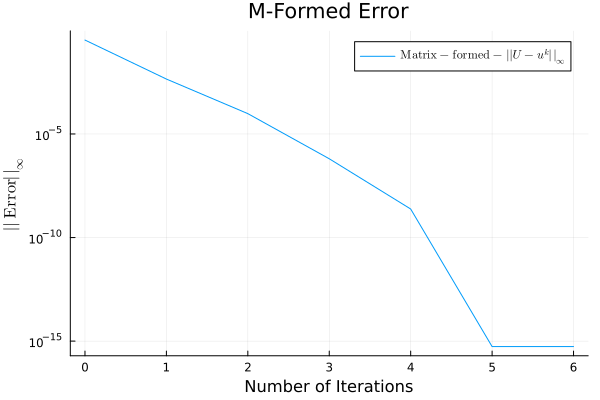

In [17]:
using LinearAlgebra, Plots, LaTeXStrings

u0 = 1.0
a = 0
b = 1.0
lambda= 1.0
f(t, u) = lambda*u
N = 18
dim=27
K = 6 # Number of Iterations
m = 3
err=zeros(K+1)
U=L3m3(dim, lambda, u0, N)
u_store=zeros(dim, K+1)
for k=1:K+1
    u_store[:, k] = L3m3k(dim, lambda, u0, N, k)
    err[k]= norm(u_store[1:m^2+4:end, k] .- U[1:m^2+4:end], Inf) .+10^(-16)
end
plot(0:K, err, 
    yaxis=:log, xlabel="Number of Iterations", 
    ylabel=L"||\mathrm{Error}||_\infty",
    title="M-Formed Error", 
    label=L"\mathrm{Matrix-formed-}\, ||U-u^k||_\infty"
)
#savefig("Level3-m3-convergence.png")

In [79]:
using SparseArrays, LinearAlgebra

function L3m3_t1(u0, lambda, N)
    # Calculate dimension based on N
    dim = N + 5 + (div(N - 1, 9) * 4)

    # Initialize parameters
    dt = 1 / N
    m = 3
    DT1 = m * dt
    DT2 = m * DT1

    d1 = lambda * DT1
    d2 = lambda * DT2

    phi = 1 / (1 - lambda * dt)
    alpha1 = (1 - d1)
    alpha2 = (1 - d2)

    # Total size of the matrix
    total_size = dim
    A = spzeros(total_size, total_size)

    # Set initial condition
    A[1, 1] = 1

    # Fill the matrix dynamically, explicitly following the pattern for arbitrary N
    pattern_indices1 = Int[]  # pattern for Level 1
    i = 2

    while i <= (dim - 2)
        # Create three groups of three consecutive numbers
        for _ in 1:3
            if i + 2 <= (dim - 2)
                append!(pattern_indices1, i:i+2...)
            end
            i += 4  # Move to the next group after completing one
        end
        # Skip two numbers after every set of three blocks
        i += 1
    end

    # Use the generated pattern to fill in the appropriate blocks in A
    for i in pattern_indices1
        if 1 <= i && i <= dim  # Ensure i is within valid bounds
            if i == pattern_indices1[1] || ((i - pattern_indices1[1]) % 4 == 0)
                A[i, i] = 1  # Only assign 1 to the diagonal block at the start of each pattern group
            else
                A[i, i - 1] = -phi
                A[i, i] = 1
            end
        end
    end

    pattern_indices2 = Int[]  # pattern for Level 2
    j = 5

    # Generate the pattern dynamically as described
    while j <= (dim - 1)
        # Create three elements with a difference of 4
        for _ in 1:3
            if j <= (dim - 1)
                push!(pattern_indices2, j)
            end
            j += 4  # Increment by 4 for the first three elements
        end
        # Switch to increment by 5 after every three elements
        j += 1  # Adding 1 here effectively makes the next difference 5
    end

    for j in pattern_indices2
        if 1 <= j && j <= dim  # Ensure j is within valid bounds
            # Embed the block matrices in A according to the generated pattern
            if j - 4 > 0
                A[j, j - 4] = -(1 + (1/8) * d1)
            end
            if j - 3 > 0
                A[j, j - 3] = -3/8 * d1
            end
            if j - 2 > 0
                A[j, j - 2] = -3/8 * d1
            end
            if j - 1 > 0
                A[j, j - 1] = 7/8 * d1
            end
            A[j, j] = alpha1
        end
    end

    # Rows with special connections involving d2 (rows 14, 27, 40, ...)
    for i in 14:13:dim
        if i <= dim
            if i - 13 > 0
                A[i, i - 13] = -(1 + (1/8) * d2)
            end
            if i - 9 > 0
                A[i, i - 9] = -3/8 * d2
            end
            if i - 5 > 0
                A[i, i - 5] = -3/8 * d2
            end
            if i - 1 > 0
                A[i, i - 1] = 7/8 * d2
            end
            A[i, i] = alpha2
        end
    end

    # Initialize the right-hand side vector
    b = spzeros(total_size)
    b[1] = u0

    # Solve the linear system
    U = A \ b  # Remove singularity check as A is assumed to be non-singular

    return U
end

L3m3_t1 (generic function with 2 methods)

In [57]:
# Convergence rate test of reference solution
using LinearAlgebra

u0 = 1.0
a=0
b=1.0
K = 6
err = zeros(K, 1)
ns=zeros(K, 1)
m=3
lambda= -1.0
f(t, u) = lambda*u

for k in 1:K
    
    N = 9* 2^k
    
    ns[k]=N
    dim, U= L3m3_t1(u0, lambda, N)
    dt=1/N
    t=(0:N)*dt
    exact= u0*exp.(lambda*t)
    err[k] = norm(exact[1:m^2+4:end] .- U[1:m^2+4:end, dim], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label=" Level Reference Solution")
display(plot!(legend=:topright))

LoadError: SingularException(2)

In [81]:
N=18
lambda=1.0
u0=1.0
U= L3m3_t1(u0, lambda, N)

27-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 1.2249999999999999
 0.0
 0.0
 0.0
 1.5006249999999997
 0.0
 0.0
 0.0
 1.8382656249999996
 ⋮
 1.7249658574826994
 1.8264344373346229
 1.81674951192746
 1.923617130276134
 2.0367710791159066
 2.156581142593313
 2.1451455678617117
 2.271330601265342
 2.4049382836927147
 2.546405241556992
 2.5329025697299774
 2.5390031817978342

In [91]:
9216 + 5 + (div(9216 - 1, 9) * 4)

13313

In [93]:
40*13313

532520